In [2]:
import os
directory = "please_add_directory"
os.chdir(directory)

from Scripts import Utilities as ut
from Scripts import Feature_Extraction as fe
from Scripts import Model_Training as mt
from Scripts import data_loading as dl
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout,BatchNormalization
from IPython.display import clear_output


In this notebook, tools are provided to freeze pretrained models and train another model on your own data while keeping part of the pretrained model frozen.

In [3]:
# Load Urban Sound
dataset = "urbansound8k"
x_train, x_val, y_train, y_val, le = dl.load_data("UrbanSound\Features\CNN_Features", dataset)

Load one model where you want to tranfer the knowledge

In [6]:
model = mt.model_load("Models\\CNN_Complex_allf_f_0pad.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 81, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 128, 81, 32)      128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 81, 32)       9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 81, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 40, 32)       0         
 )                                                               
                                                        

Choose how many layers you want to freeze and drop the rest

In [7]:
freeze_layers = 5
mt.freeze_and_delete_layers(model, freeze_layers)

Now add whatever layers you want to the model

In [8]:
model.add(Conv2D(64, (3, 3),strides=(1, 1), padding='same', activation='relu',name ="convh64"))
model.add(BatchNormalization(name = "Batch_1"))                          
model.add(MaxPooling2D(2, 2, name = "mx_pl_7")) 
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3),strides=(1, 1), padding='same', activation='relu', name = 'conv128'))
model.add(BatchNormalization(name = "Batch_2"))                          
model.add(MaxPooling2D(2, 2, name = "mx_pl_8"))  
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2, name = "one"))
model.add(Dense(10, activation='softmax'))


learning_rate= 0.0001
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=([mt.f1_score],['accuracy']))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 81, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 128, 81, 32)      128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 81, 32)       9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 81, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 40, 32)       0         
 )                                                               
                                                        

In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=10, verbose=1)
checkpoint = ModelCheckpoint( 'Models\\temp.h5',monitor='val_f1_score', verbose=1,   save_best_only=True, mode='max' )

hist = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100, callbacks = [early_stopping,checkpoint],
    batch_size=32
    )

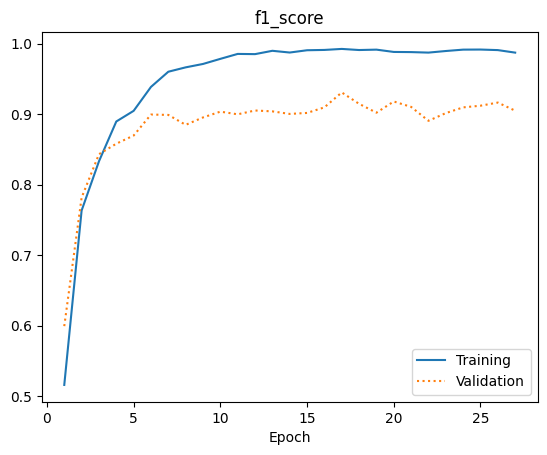

In [20]:
# Plots for evaluating the model

_ = hist.history['f1_score']
c = hist.history['val_f1_score']
mt.plot_training_history(_,c,"f1_score")

66/66 [==============================] - 1s 7ms/step
Accuracy: 0.9312320916905444
F1 Score: 0.9313342267084553


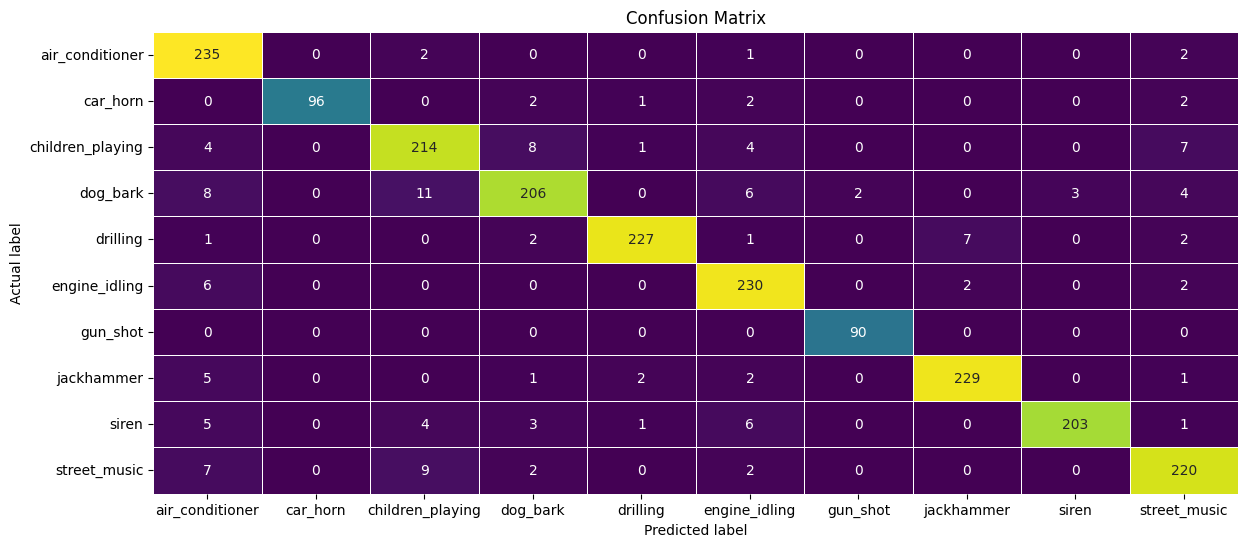

In [23]:
# Confusion Matrix

mt.plot_confusion_matrix(model,x_val,y_val,le)

In [22]:
model = mt.model_load("Models\\temp.h5")
clear_output()
model.save(f"Models\\Final_Models\\Transfer_Learning_Stride_final.h5")

# Transfer Learning With YamNet

In [24]:
# The dataset is the same we choose YamNet because this is the features we have

dataset = "YamNet"
x_train, x_val, y_train, y_val, le =  dl.load_data("UrbanSound\Features\YamNet_Features\Train_Features", dataset)

A model is builded now based of the output of YamNet embedings.

In [31]:
model = mt.Fully_Connected_YamNet()

learning_rate= 0.00005
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=([mt.f1_score],['accuracy']))
model.summary()


early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=15, verbose=1)
checkpoint = ModelCheckpoint( 'Models\\temp.h5',monitor='val_f1_score', verbose=1,   save_best_only=True, mode='max' )

hist = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200, callbacks = [early_stopping,checkpoint],
    batch_size=32
    )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 1024)              0         
                                                                 
 dense_24 (Dense)            (None, 2048)              2099200   
                                                                 
 dropout_16 (Dropout)        (None, 2048)              0         
                                                                 
 dense_25 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_17 (Dropout)        (None, 1024)              0         
                                                                 
 dense_26 (Dense)            (None, 512)               524800    
                                                                 
 dropout_18 (Dropout)        (None, 512)              

Plot the Results of your preferance, change accuracy for f1_score if you prefer this metric

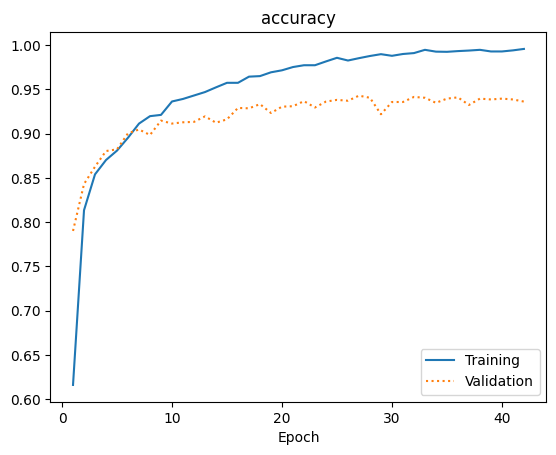

66/66 [==============================] - 0s 1ms/step
Accuracy: 0.9427480916030534
F1 Score: 0.9427811519750968


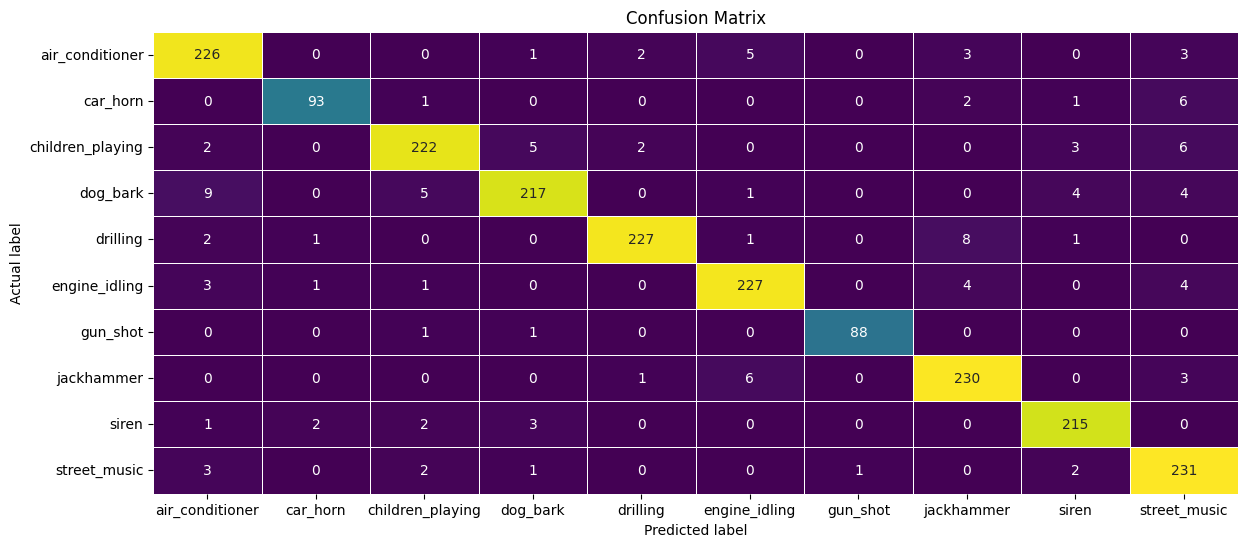

In [34]:
_ = hist.history['accuracy']
c = hist.history['val_accuracy']
mt.plot_training_history(_,c,"accuracy")
mt.plot_confusion_matrix(model,x_val,y_val,le)

Dont forget to save yout model for later use

In [33]:
model = mt.model_load("Models\\temp.h5")
clear_output()
model.save(f"Models\\Final_Models\\YamNet.h5")